In [1]:
import math
import numpy as np
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
from scipy.misc import imresize
from skimage import feature

In [2]:
# helpers

# plot images, list are dislayed in subplots
def plot(imgs, title=None):
    # make sure input is a list
    if not isinstance(imgs, list):
        imgs = [imgs]
    
    plt.figure()
        
    for i in range(len(imgs)):
        if(title is not None): 
            plt.suptitle(title)
        plt.subplot(1, len(imgs), i+1)
        plt.axis("off")
        # fix channels for rgb
        if len(imgs[i].shape) > 2:
            plt.imshow(imgs[i][:,:,[2,1,0]])
        else:
            plt.imshow(imgs[i])
        

# create empty list of given size
def empty(size):
    return [None]*size


# calculate center column of image
def center_column(img):
    # sum up columns
    colsum = np.sum(img, axis=0)
    
    # get left and right boundaries
    left = np.min(np.nonzero(colsum))
    right = np.max(np.nonzero(colsum))
    
    # calc cumulative sum
    cumsum = np.cumsum(colsum[left:right])
    
    # return index closest to mean
    return left+(np.abs(cumsum-np.mean(cumsum))).argmin()


# calculate masks from seg
def mask2(img):
    return img>120


def mask3(img):
    return np.tile(mask2(img), (3,1,1)).transpose((1,2,0))


print('done')

done


In [3]:
# extract boundary info (top, bottom,...)
def extract_info(sample_id):
    
    seg = data['segmentation'][sample_id][:,:,0]
    
    # init dict
    info = {}
    info['id'] = sample_id
    
    # calculate top and bottom crop
    info['top'] = np.min(np.nonzero(np.any(seg, axis=1)))
    info['bottom'] = np.max(np.nonzero(np.any(seg, axis=1)))
    
    # calculate (scale-adjusted) number of nonzeros
    height = info['bottom']-info['top']
    factor = (120/height)**2
    
    info['nonzeros'] = int((seg>0).sum()*factor)
    
    return info

print('done')

done


In [4]:
# params
set_name = 'train'

In [5]:
# load data
data = pickle.load(open('./data/data-{}.pkl'.format(set_name), 'rb'))
n_samples = data['rgb'].shape[0]

print('%i samples' % n_samples)
print('done')

77421 samples
done


In [6]:
subjects = list(set(data['subjectLabels']))
sub_data = {}

for sub_id in subjects:
    sub_data[sub_id] = {'samples': []}

for i, sub_id in enumerate(data['subjectLabels']):
    sub_data[sub_id]['samples'].append(extract_info(i))
    
print('done')

done


In [7]:
for sub_id in subjects:
    samples = sub_data[sub_id]['samples']
    
    nonzeros = int(sum([sample['nonzeros'] for sample in samples])/len(samples))
    bottom = int(sum([sample['bottom'] for sample in samples])/len(samples))
    top = int(sum([sample['top'] for sample in samples])/len(samples))
    height = bottom-top
    
    bottom = int(top+(nonzeros/5000)*height) # may be >119
    height = bottom-top
    top = int(top-height*0.1) # may be <0! always >=-12 (0-120*0.1)
    
    sub_data[sub_id]['nonzeros'] = nonzeros
    sub_data[sub_id]['bottom'] = bottom
    sub_data[sub_id]['top'] = top

In [8]:
def process(i):
    sample = data['segmentation'][i][:, :, 0]
    sub_id = data['subjectLabels'][i]
    
    # crop and scale segmentation to calculate body area
    
    # retrieve top and bottom crop
    top = sub_data[sub_id]['top']
    bottom = sub_data[sub_id]['bottom']
    
    # calculate center column
    center = center_column(sample[max(0, top):bottom, :])
    
    dim_out = (96,96)
    pad_hor = (48,48)
    pad_ver = (48,48)
    
    # calculate scaling factor
    factor = dim_out[0]/(bottom-top)
    
    # calculate left and right crop
    left  = pad_hor[0]+center-int((dim_out[0]/2)/factor)
    right = pad_hor[0]+center+int((dim_out[0]/2)/factor)
    
    # adjust top and bottom crop (for padding)
    top    += pad_ver[0]
    bottom += pad_ver[0]

    # pad originals (in case person is way off-center and left<0, right>=90, or top<0)
    rgb_tmp = data['rgb'][i].copy()
    rgb_tmp = np.lib.pad(rgb_tmp, (pad_ver, (0, 0), (0, 0)), 'edge')
    rgb_tmp = np.lib.pad(rgb_tmp, ((0, 0), pad_hor, (0, 0)), 'constant')
    
    seg_tmp = data['segmentation'][i][...,0].copy()
    seg_tmp = np.lib.pad(seg_tmp, (pad_ver, (0, 0)), 'edge')
    seg_tmp = np.lib.pad(seg_tmp, ((0, 0), pad_hor), 'constant')

    dep_tmp = data['depth'][i].copy()
    dep_tmp = np.lib.pad(dep_tmp, (pad_ver, (0, 0)), 'edge')
    dep_tmp = np.lib.pad(dep_tmp, ((0, 0), pad_hor), 'constant')
    
    # crop and resize
    rgb = cv2.resize(rgb_tmp[top:bottom, left:right, :], dim_out, interpolation=cv2.INTER_CUBIC)
    seg = cv2.resize(seg_tmp[top:bottom, left:right   ], dim_out, interpolation=cv2.INTER_CUBIC)
    dep = cv2.resize(dep_tmp[top:bottom, left:right   ], dim_out, interpolation=cv2.INTER_CUBIC)
    
    # mask rgb and depth
    rgb *= mask3(seg)
    dep *= mask2(seg)

    return rgb, seg, dep

In [9]:
# initialize data_pp
data_pp = np.zeros(shape=n_samples, dtype=[('rgb', np.uint8, (96, 96, 3)),
                                           ('seg', np.uint8, (96, 96)),
                                           ('dep', np.uint8, (96, 96)),
                                           ('sub', np.uint8),
                                           ('lbl', np.uint8)
                                          ])

for i in range(n_samples):

    # copy labels
    data_pp['sub'][i] = data['subjectLabels'][i]

    if set_name == 'train':
        data_pp['lbl'][i] = data['gestureLabels'][i]

    # process sample
    rgb, seg, dep = process(i)

    # write to chunk
    data_pp['seg'][i] = seg
    data_pp['rgb'][i] = rgb
    data_pp['dep'][i] = dep

print(data_pp.shape)
print('done')

(77421,)
done


In [11]:
# normalize depth
for sub_id, sub in sub_data.items():
    
    sample_ids = [sample['id'] for sample in sub['samples']]
    
    deps = [data_pp['dep'][sample_id] for sample_id in sample_ids]
    segs = [data_pp['seg'][sample_id] for sample_id in sample_ids]
    
    avg_mean = sum(dep[dep>0].mean() for dep in deps)/len(deps)
    avg_std = sum(dep[dep>0].std() for dep in deps)/len(deps)
    
    for dep, seg in zip(deps, segs):
        
        # convert to signed type, so we can shift to mean=0
        signed = dep.astype(dtype=int)

        # shift mean to 0, fix std to 16, move mean to 128
        signed = signed-avg_mean
        signed = signed*(16/avg_std)
        signed = signed+128

        # store into old container
        dep[...] = signed.astype(np.uint8)[...]
        
        # re-apply mask and set background to max distance
        dep *= mask2(seg)
        dep[dep==0] = 255
        
print('done')

done


In [12]:
s = 10000
for i in range(s,s+20):
    plot([data['rgb'][i], data_pp['rgb'][i]], 'rgb({})'.format(i))
    plot([data['depth'][i], data_pp['dep'][i]], 'depth({})'.format(i))

NameError: name 'data' is not defined

In [13]:
pickle.dump(data_pp, open('./data_pp/{}_sa.pkl'.format(set_name), 'wb'))
print('done')

done


In [ ]:
# dump to disk (in chunks)
max_chunk_size = 10000
dumped = 0
chunk_id = 0

while dumped < n_samples:
    
    chunk_size = min(n_samples-dumped, max_chunk_size)
    
    chunk = {
        'seg': data_pp['seg'][dumped:dumped+chunk_size],
        'rgb': data_pp['rgb'][dumped:dumped+chunk_size],
        'dep': data_pp['dep'][dumped:dumped+chunk_size],
        'sub': data_pp['sub'][dumped:dumped+chunk_size],
        'lbl': data_pp['lbl'][dumped:dumped+chunk_size],
    }
    
    # write to disk
    pickle.dump(chunk, open('./data_pp/%s_%i.pkl' % (set_name, chunk_id), 'wb'))
    print('dumped chunk #%i to \'./data_pp/%s_%i.pkl\' (%i samples)' % (chunk_id, set_name, chunk_id, chunk_size))
    
    del chunk
    
    dumped += chunk_size
    chunk_id += 1
    
print('done')

In [14]:
data_pp = pickle.load(open('./data_pp/{}_sa.pkl'.format(set_name), 'rb'))

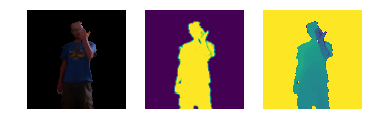

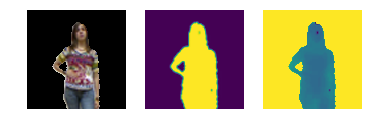

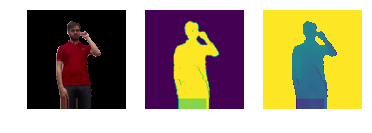

In [15]:
plot(list(data_pp[1000])[0:3])
plot(list(data_pp[2000])[0:3])
plot(list(data_pp[3000])[0:3])

In [10]:
# clear original data
del data